In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

# Paths to your datasets
data_dir = "E:/skin_cancer_dataset/dataset"
classes = ["vasc", "df", "akeic"]

# Load images and labels
X, y = [], []
for label, folder in enumerate(classes):
    folder_path = os.path.join(data_dir, folder)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.utils.img_to_array(img)
        X.append(img_array)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True, rescale=1.0/255
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [ ]:
 #Load the VGG19 model without the top layer
print("Loading a fresh VGG19 model...")
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Replace '3' with the number of classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summarize the model
model.summary()


Loading a fresh VGG19 model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,448,963 (100.89 MB)

 Trainable params: 6,424,067 (24.51 MB)

 Non-trainable params: 20,024,896 (76.39 MB)

In [ ]:
# Train the model for 100 epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]
)

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator)+

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.5552 - loss: 1.2305 - val_accuracy: 0.7407 - val_loss: 0.6792 - learning_rate: 1.0000e-04
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.7367 - loss: 0.6243 - val_accuracy: 0.5679 - val_loss: 0.8937 - learning_rate: 1.0000e-04
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.7984 - loss: 0.5063 - val_accuracy: 0.6296 - val_loss: 0.8146 - learning_rate: 1.0000e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.7879 - loss: 0.5705 - val_accuracy: 0.6358 - val_loss: 0.7676 - learning_rate: 1.0000e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.8029 - loss: 0.5015 - val_accuracy: 0.7901 - val_loss: 0.5365 - learning_rate: 2.0000e-05
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - accuracy: 0.8384 - loss: 0.4573 - val_accuracy: 0.8395 - val_loss: 0.4480 - learning_rate: 2.0000e-05
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 

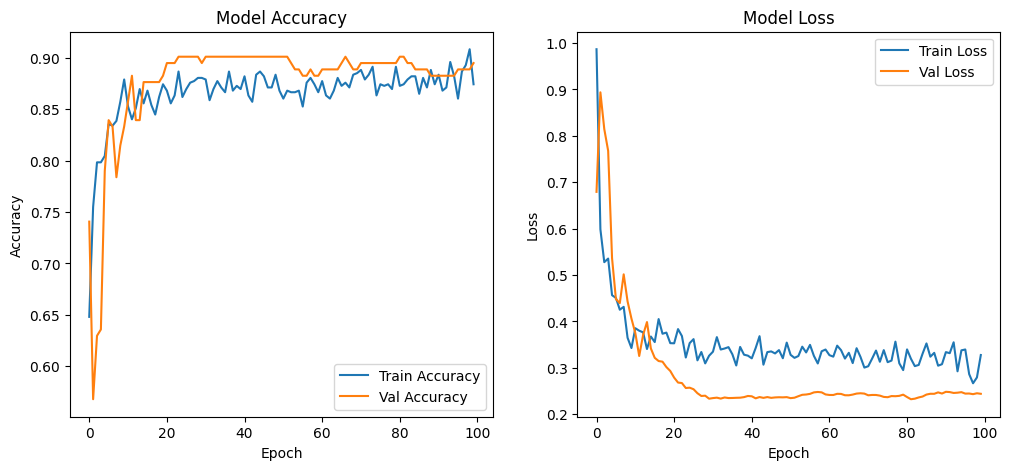

In [ ]:
# Plot accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

